In [1]:
import pandas as pd
from ast import literal_eval
df = pd.read_csv(filepath_or_buffer='/kaggle/input/inshorts-dataset-english/english_news_dataset.csv', parse_dates=['Date'], dayfirst=True)
df.head()

,Headline,Content,News Categories,Date
0,Congress leader Baljinder Singh shot dead at h...,Congress leader Baljinder Singh was shot dead ...,['national'],19-09-2023
1,17-year-old girl preparing for NEET dies by su...,Another NEET aspirant died by suicide in Rajas...,['national'],19-09-2023
2,Hampers to welcome MPs in new Parliament tomor...,In order to mark the first-ever working day of...,['national'],19-09-2023
3,"Only 10% women lawmakers in RS, while only 14%...","Congress President Mallikarjun Kharge, while s...",['national'],19-09-2023
4,"Ganesh temple decorated with notes, coins wort...",The Sri Sathya Ganapathi Temple in Bengaluru a...,['national'],19-09-2023


In [2]:

from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.random import random
def get_tfidf(arg_df: pd.DataFrame, column: str, stopwords: list):
    min_df = 10
    stop_words = stopwords + list(STOPWORDS) + ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn']
    tfidf = TfidfVectorizer(stop_words=stop_words, min_df=min_df,
                            # https://stackoverflow.com/questions/45981037/sklearn-tf-idf-to-drop-numbers
                           token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', 
                           )
    tfidf_result = tfidf.fit_transform(raw_documents=[item for item in arg_df[column].fillna('').values.tolist() if item != ''])
    tfidf_df = pd.DataFrame(tfidf_result.toarray(), columns = tfidf.get_feature_names_out()).sum(axis=0).to_frame().reset_index().rename(columns={'index': 'token', 0 : 'tfidf'})
    tfidf_df['random'] = random(size=len(tfidf_df)) * tfidf_df['tfidf']
    return tfidf_df, tfidf_result, tfidf.get_feature_names_out()
print('built get tfidf')

built get tfidf


In [3]:
from plotly.express import scatter

def startswith_type(char: str) -> str:
    if char in list('1234567890'):
        return 'number' 
    if char in list('aeiouy'):
        return 'vowel' 
    return 'consonant'

stopwords = ['d', 'm', 's', 't', 'b', 'india', 'indian', ]
tfidf_df, tfidf_result , tfidf_features = get_tfidf(arg_df=df, column='Headline', stopwords=stopwords)
tfidf_df['startswith'] = tfidf_df['token'].str[0]
tfidf_df['startswith_type'] = tfidf_df['startswith'].apply(func=startswith_type)
scatter(data_frame=tfidf_df, x='random', y='tfidf', hover_name='token', log_x=True, log_y=True, color='startswith_type',
       title='Headline random/relevance plot').show()

In [4]:
from plotly.express import strip
strip(data_frame=tfidf_df, y='tfidf', hover_name='token', log_y=True, x='startswith')

This is not a great way to visualize this data but it will suffice for the moment.

In [5]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(verbose=1, random_state=2023, n_components=15, max_iter=15, )
lda_result = lda.fit_transform(X=tfidf_result)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15


In [6]:
# copied from 
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 5, figsize=(30, 20), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
print('built plot top words')

built plot top words


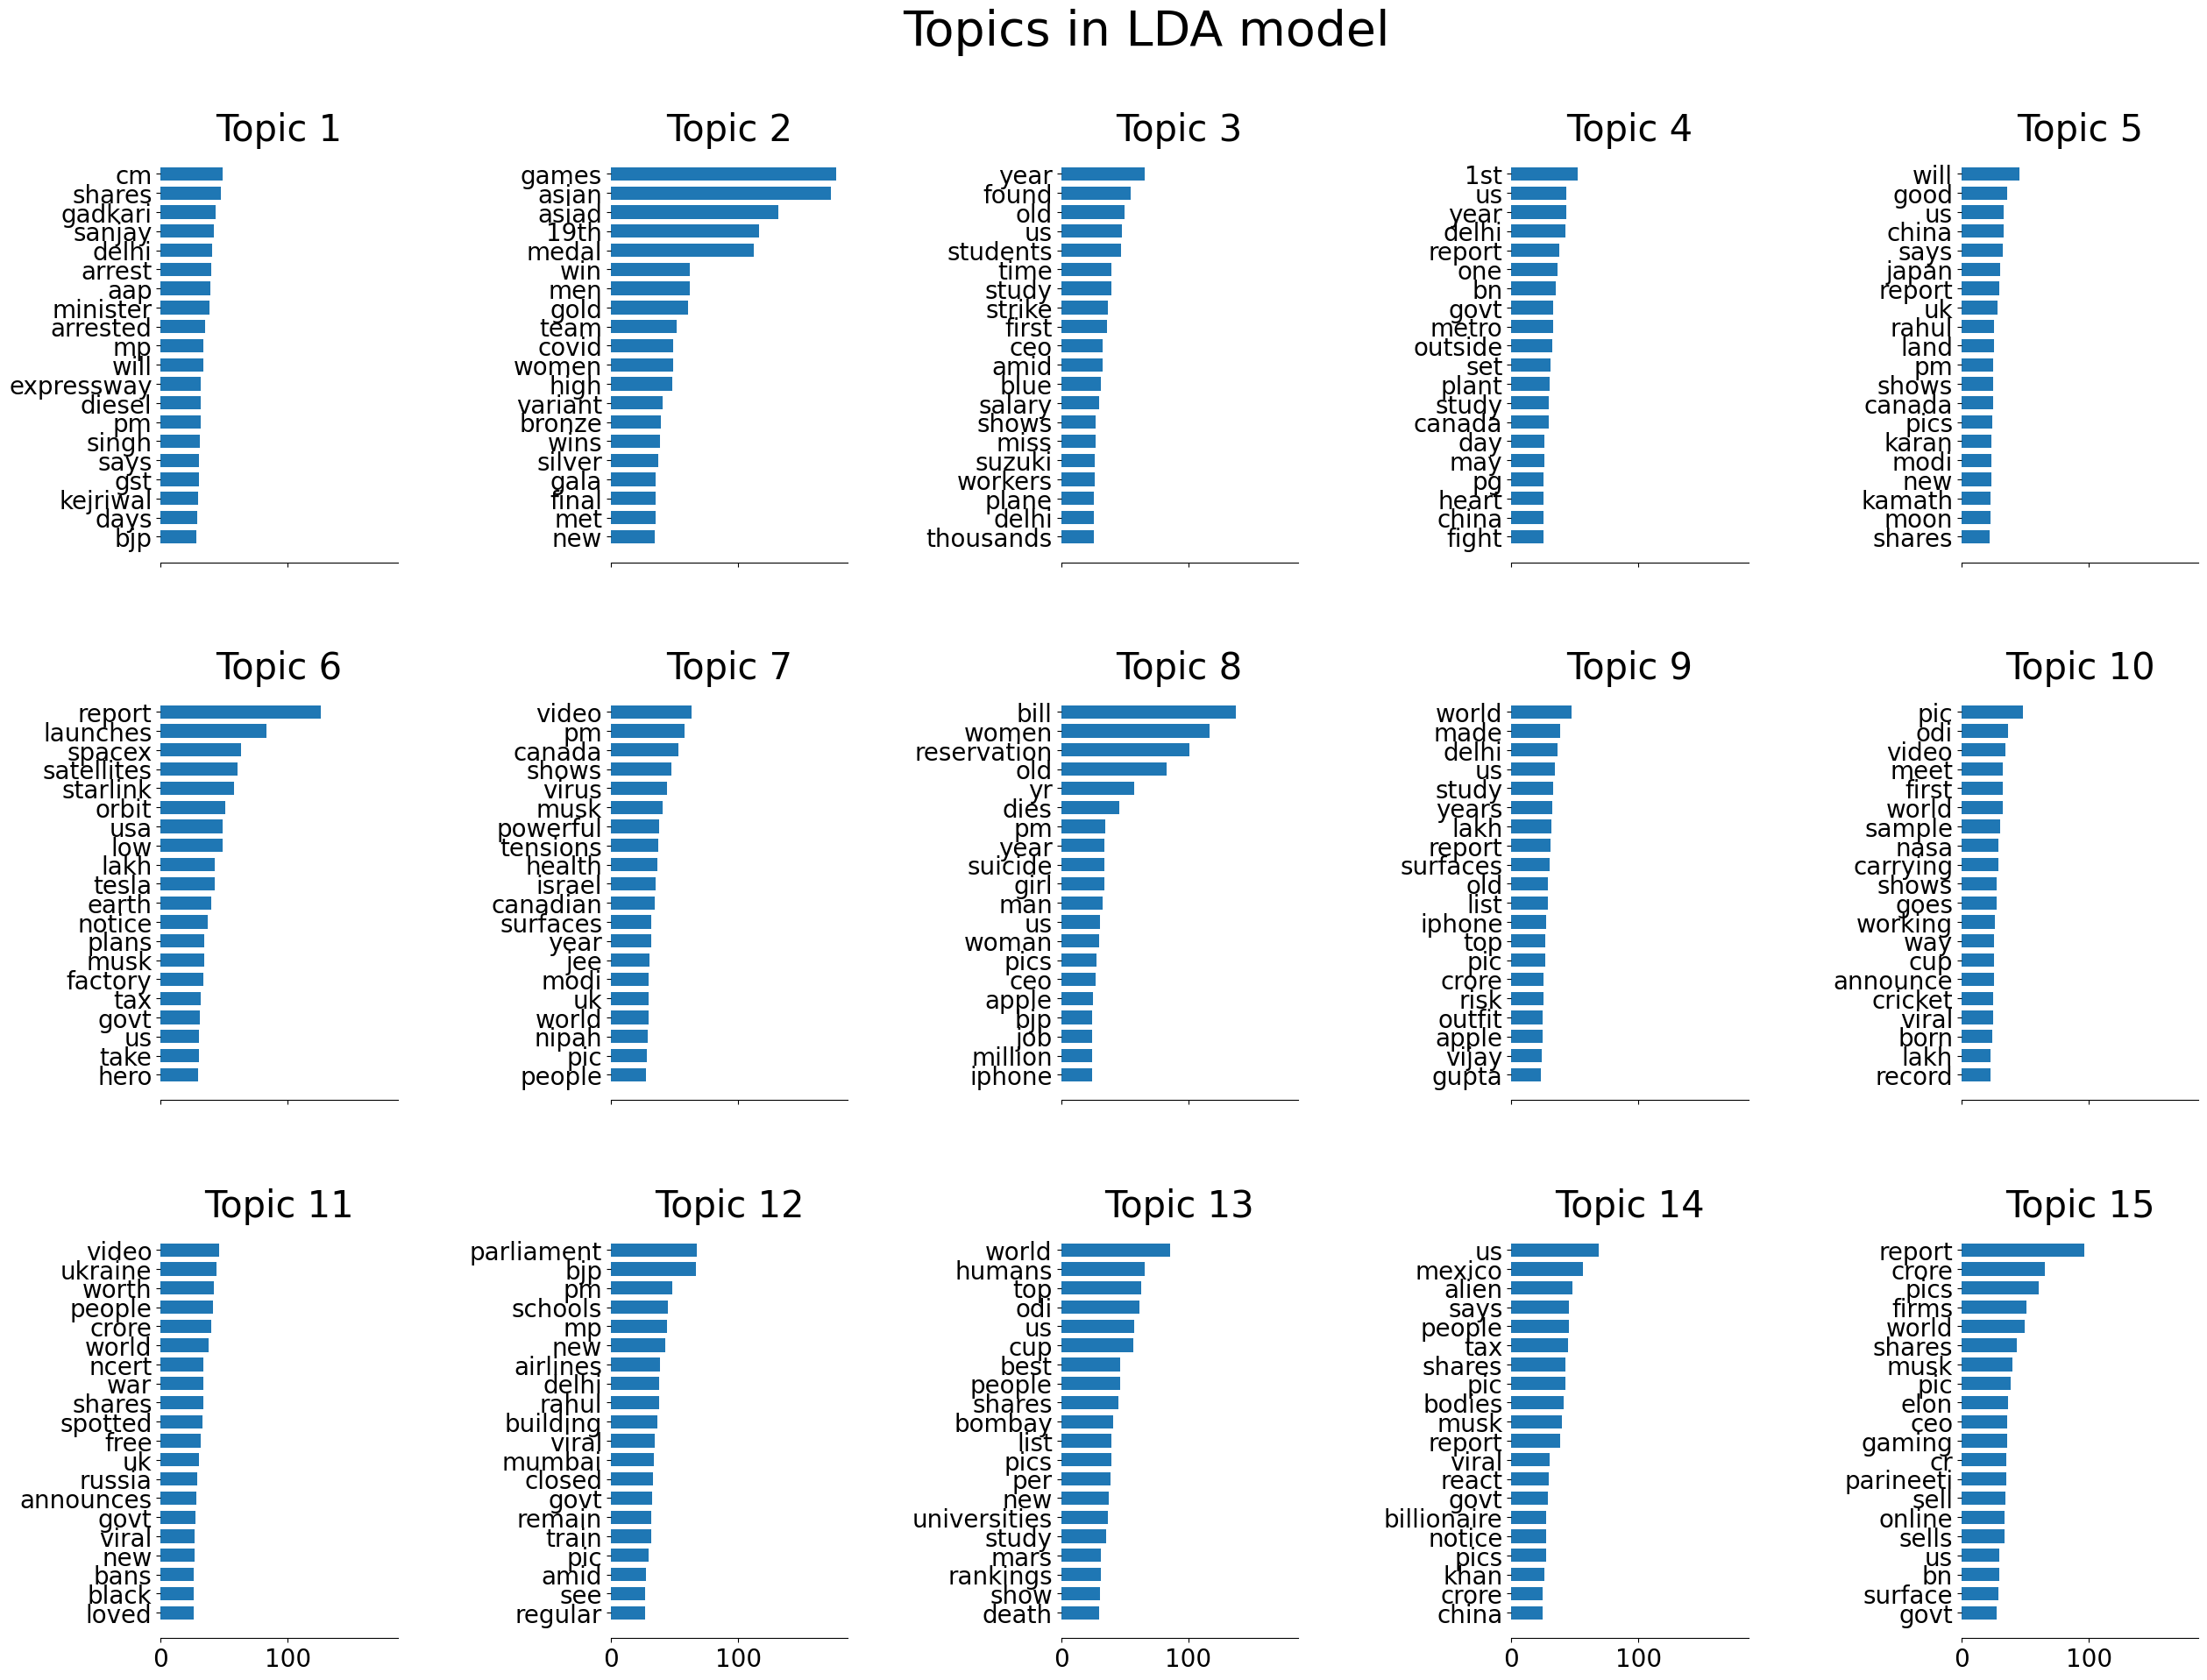

In [7]:
plot_top_words(model=lda, feature_names=tfidf_features, n_top_words=20, title='Topics in LDA model')